<a href="https://colab.research.google.com/github/awaw24/Weather_Forecast_Project/blob/main/Projekt_z_Pythona.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Wykonał:**

Arkadiusz Pizon

Grupa: MZ01IP1

Nr albumu: 22267

**Źródło danych:**
https://www.kaggle.com/datasets/selfishgene/historical-hourly-weather-data

Inicjalizacja

In [1]:
!pip install kaggle

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found, przestaw środowisko wykonawcze do obsługi T4 GPU (wykonuje obliczenia ponad 2x szybciej). Kliknij, Środowisko wykonawcze --> Zmień typ środowiska wykonawczego --> Akcelerator sprzętowy == T4 GPU --> ZAPISZ')
print('Found GPU at: {}'.format(device_name))

# Ustawienia konfiguracyjne dla wykresów
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Found GPU at: /device:GPU:0


In [3]:
from google.colab import files
# Upload the kaggle.json file
#uploaded = files.upload()
!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/
!echo '{"username":"arkadiuszpizon","key":"3c3a9f417acea444ab7079f157abb429"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d selfishgene/historical-hourly-weather-data
!unzip -qn historical-hourly-weather-data.zip

 50% 6.00M/12.0M [00:00<00:00, 62.5MB/s]
100% 12.0M/12.0M [00:00<00:00, 102MB/s] 


Wczytanie plików

In [4]:
df_temperature = pd.read_csv('temperature.csv')
df_humidity = pd.read_csv('humidity.csv')
df_pressure = pd.read_csv('pressure.csv')
df_weather_description = pd.read_csv('weather_description.csv')
df_wind_direction = pd.read_csv('wind_direction.csv')
df_wind_speed = pd.read_csv('wind_speed.csv')

Wstępna weryfkiacja

In [5]:
df_temperature.head()

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,309.100000,NaN,NaN,NaN
1,2012-10-01 13:00:00,284.630000,282.080000,289.480000,281.800000,291.870000,291.530000,293.410000,296.600000,285.120000,...,285.630000,288.220000,285.830000,287.170000,307.590000,305.470000,310.580000,304.4,304.4,303.5
2,2012-10-01 14:00:00,284.629041,282.083252,289.474993,281.797217,291.868186,291.533501,293.403141,296.608509,285.154558,...,285.663208,288.247676,285.834650,287.186092,307.590000,304.310000,310.495769,304.4,304.4,303.5
3,2012-10-01 15:00:00,284.626998,282.091866,289.460618,281.789833,291.862844,291.543355,293.392177,296.631487,285.233952,...,285.756824,288.326940,285.847790,287.231672,307.391513,304.281841,310.411538,304.4,304.4,303.5
4,2012-10-01 16:00:00,284.624955,282.100481,289.446243,281.782449,291.857503,291.553209,293.381213,296.654466,285.313345,...,285.850440,288.406203,285.860929,287.277251,307.145200,304.238015,310.327308,304.4,304.4,303.5


Analiza pod względem braku danych dla poszczególnych miast

In [6]:
dfs = [df_temperature, df_humidity, df_pressure, df_weather_description, df_wind_direction, df_wind_speed]
new_column_names = ["temp", "humid", "press", "descr", "w_dir", "w_speed"]
nan_counts = pd.concat([df.isnull().sum() for df in dfs], axis=1, keys=new_column_names)

nan_counts['Row_Sum'] = nan_counts.sum(axis=1)
nan_counts_sorted = nan_counts.sort_values(by='Row_Sum', ascending=True)

print("NaN occurrences in each column:")
print(nan_counts_sorted)

NaN occurrences in each column:
                   temp  humid  press  descr  w_dir  w_speed  Row_Sum
datetime              0      0      0      0      0        0        0
Houston               3    121      9      1      2        3      139
Jacksonville          1    209     15      1      5        1      232
Seattle               3    289     13      1      1        1      308
Dallas                4    319     60      1      1        2      387
Los Angeles           3    152    252      1      1        1      410
Portland              1    449      4      1      1        1      457
Boston                3    449      7      1      1        1      462
Atlanta               6    422     49      1      1        1      480
San Diego             1    344    175      1      1        1      523
Minneapolis          13    510     17      1      1        3      545
Pittsburgh            3    522     46      1      1        1      574
San Antonio           1    564     17      1      1       

Wybieranie danych dla **San Diego** i połączenie dataframe'ów w jedno

In [7]:
df_temperature = pd.read_csv('temperature.csv')
df_humidity = pd.read_csv('humidity.csv')
df_pressure = pd.read_csv('pressure.csv')
df_weather_description = pd.read_csv('weather_description.csv')
df_wind_direction = pd.read_csv('wind_direction.csv')
df_wind_speed = pd.read_csv('wind_speed.csv')

city = 'San Diego'
df_datetime = pd.to_datetime(df_temperature['datetime'], format='%Y-%m-%d %H:%M:%S')
df_temperature = df_temperature[[city]].rename(columns={city: 'temperature'})
df_humidity = df_humidity[[city]].rename(columns={city: 'humidity'})
df_pressure = df_pressure[[city]].rename(columns={city: 'pressure'})
df_weather_description = df_weather_description[[city]].rename(columns={city: 'description'})
df_wind_direction = df_wind_direction[[city]].rename(columns={city: 'wind_dir'})
df_wind_speed = df_wind_speed[[city]].rename(columns={city: 'wind_speed'})

df_weather = pd.concat([df_datetime, df_temperature, df_humidity, df_pressure, df_weather_description, df_wind_direction, df_wind_speed], axis=1)

Dane na których pracuję to __df_weather__ i dotyczą miasta **San Diego**

In [8]:
df_weather.head()

,datetime,temperature,humidity,pressure,description,wind_dir,wind_speed
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-10-01 13:00:00,291.530000,82.0,1013.0,sky is clear,0.0,0.0
2,2012-10-01 14:00:00,291.533501,81.0,1013.0,sky is clear,0.0,0.0
3,2012-10-01 15:00:00,291.543355,81.0,1013.0,sky is clear,0.0,0.0
4,2012-10-01 16:00:00,291.553209,81.0,1013.0,sky is clear,0.0,0.0


In [9]:
weather_count = df_weather[['description']].value_counts()
print(weather_count)

description                 
sky is clear                    14829
broken clouds                    7407
scattered clouds                 4500
mist                             4152
few clouds                       4012
haze                             3319
overcast clouds                  2839
light rain                       2288
fog                               971
moderate rain                     515
light intensity drizzle           156
heavy intensity rain              127
drizzle                            54
smoke                              35
thunderstorm                       12
squalls                            10
proximity thunderstorm              9
very heavy rain                     7
thunderstorm with rain              5
thunderstorm with light rain        3
light intensity shower rain         1
shower rain                         1
dtype: int64


Analiza pod kątem występowania braku danych w DataFramie dla San Diego

Wyświetlenie liczby brakujących danych w poszczególnych kolumnach

In [10]:
df_weather.isna().sum()

datetime         0
temperature      1
humidity       344
pressure       175
description      1
wind_dir         1
wind_speed       1
dtype: int64

Wyświetlenie wszystkich wierszy w których występują braki

In [11]:
nan_values = df_weather[df_weather.isna().any(axis=1)]

pd.set_option('display.max_rows', None)

print (nan_values)

                 datetime  temperature  humidity  pressure  \
0     2012-10-01 12:00:00          NaN       NaN       NaN   
342   2012-10-15 18:00:00   296.910000       NaN       NaN   
389   2012-10-17 17:00:00   293.950000       NaN       NaN   
391   2012-10-17 19:00:00   297.390000       NaN       NaN   
535   2012-10-23 19:00:00   292.480000       NaN       NaN   
635   2012-10-27 23:00:00   300.370000       NaN    1013.0   
846   2012-11-05 18:00:00   297.810000       NaN       NaN   
848   2012-11-05 20:00:00   301.660000       NaN       NaN   
849   2012-11-05 21:00:00   302.085000       8.0       NaN   
999   2012-11-12 03:00:00   285.700000       NaN       NaN   
1000  2012-11-12 04:00:00   287.185000      24.0       NaN   
1024  2012-11-13 04:00:00   285.250000       NaN       NaN   
1038  2012-11-13 18:00:00   289.700000       NaN       NaN   
1051  2012-11-14 07:00:00   282.350000       NaN    1021.0   
1053  2012-11-14 09:00:00   282.140000       NaN    1021.0   
1062  20

In [12]:
hum_mean = df_weather.loc[:,"humidity"].mean()
press_mean = df_weather.loc[:,"pressure"].mean()
df_weather = df_weather.fillna(value={'humidity':hum_mean,'pressure':press_mean,'temperature':291.530000,'description': "sky is clear",'wind_dir':0.0,'wind_speed':0.0 })

Wyświetlenie liczby brakujących danych w poszczególnych kolumnach

In [13]:
df_weather.isna().sum()

datetime       0
temperature    0
humidity       0
pressure       0
description    0
wind_dir       0
wind_speed     0
dtype: int64

Wyświetlenie wszystkich wierszy w których występują braki

In [14]:
nan_values = df_weather[df_weather.isna().any(axis=1)]

pd.set_option('display.max_rows', None)

print (nan_values)

Empty DataFrame
Columns: [datetime, temperature, humidity, pressure, description, wind_dir, wind_speed]
Index: []


Dodanie kolumn: **rain_exists** oraz **cloud_ exists**

Sprawdzenie wartości przed zmianą

In [15]:
df_weather.head()

,datetime,temperature,humidity,pressure,description,wind_dir,wind_speed
0,2012-10-01 12:00:00,291.530000,67.784809,1017.524491,sky is clear,0.0,0.0
1,2012-10-01 13:00:00,291.530000,82.000000,1013.000000,sky is clear,0.0,0.0
2,2012-10-01 14:00:00,291.533501,81.000000,1013.000000,sky is clear,0.0,0.0
3,2012-10-01 15:00:00,291.543355,81.000000,1013.000000,sky is clear,0.0,0.0
4,2012-10-01 16:00:00,291.553209,81.000000,1013.000000,sky is clear,0.0,0.0


Tworzenie kolumny **rain_exists**

In [16]:
df_weather.loc[(df_weather['description'] == 'light rain') | (df_weather['description'] == 'moderate rain') | (df_weather['description'] == 'light intensity drizzle') | (df_weather['description'] == 'drizzle') | (df_weather['description'] == 'squalls') | (df_weather['description'] == 'heavy intensity rain') | (df_weather['description'] == 'thunderstorm') | (df_weather['description'] == 'shower rain') | (df_weather['description'] == 'very heavy rain') | (df_weather['description'] == 'thunderstorm with light rain') | (df_weather['description'] == 'thunderstorm with rain') | (df_weather['description'] == 'light intensity shower rain'), 'rain_exists'] = 1
df_weather.loc[(df_weather['description'] != 'light rain') & (df_weather['description'] != 'moderate rain') & (df_weather['description'] != 'light intensity drizzle') & (df_weather['description'] != 'drizzle') & (df_weather['description'] != 'squalls') & (df_weather['description'] != 'heavy intensity rain') & (df_weather['description'] != 'thunderstorm') & (df_weather['description'] != 'shower rain') & (df_weather['description'] != 'very heavy rain') & (df_weather['description'] != 'thunderstorm with light rain') & (df_weather['description'] != 'thunderstorm with rain') & (df_weather['description'] != 'light intensity shower rain'), 'rain_exists'] = 0

df_weather['rain_exists'] = df_weather['rain_exists'].astype('bool')

Tworzenie kolumny **cloud_exists**

In [17]:
df_weather.loc[(df_weather['description'] == 'light rain') | (df_weather['description'] == 'moderate rain') | (df_weather['description'] == 'light intensity drizzle') | (df_weather['description'] == 'drizzle') | (df_weather['description'] == 'squalls') | (df_weather['description'] == 'heavy intensity rain') | (df_weather['description'] == 'thunderstorm') | (df_weather['description'] == 'shower rain') | (df_weather['description'] == 'very heavy rain') | (df_weather['description'] == 'thunderstorm with light rain') | (df_weather['description'] == 'thunderstorm with rain') | (df_weather['description'] == 'light intensity shower rain') | (df_weather['description'] == 'few clouds') | (df_weather['description'] == 'scattered clouds') | (df_weather['description'] == 'broken clouds') | (df_weather['description'] == 'overcast clouds') | (df_weather['description'] == 'proximity thunderstorm'), 'cloud_exists'] = 1
df_weather.loc[(df_weather['description'] != 'light rain') & (df_weather['description'] != 'moderate rain') & (df_weather['description'] != 'light intensity drizzle') & (df_weather['description'] != 'drizzle') & (df_weather['description'] != 'squalls') & (df_weather['description'] != 'heavy intensity rain') & (df_weather['description'] != 'thunderstorm') & (df_weather['description'] != 'shower rain') & (df_weather['description'] != 'very heavy rain') & (df_weather['description'] != 'thunderstorm with light rain') & (df_weather['description'] != 'thunderstorm with rain') & (df_weather['description'] != 'light intensity shower rain') & (df_weather['description'] != 'few clouds') & (df_weather['description'] != 'scattered clouds') & (df_weather['description'] != 'broken clouds') & (df_weather['description'] != 'overcast clouds') & (df_weather['description'] != 'proximity thunderstorm'), 'cloud_exists'] = 0

df_weather['cloud_exists'] = df_weather['cloud_exists'].astype('bool')

Usuwanie kolumny **description**

In [18]:
df_weather.drop(['description'], inplace=True, axis=1)

Sprawdzenie wartości po zmianie

In [19]:
df_weather.head()

,datetime,temperature,humidity,pressure,wind_dir,wind_speed,rain_exists,cloud_exists
0,2012-10-01 12:00:00,291.530000,67.784809,1017.524491,0.0,0.0,False,False
1,2012-10-01 13:00:00,291.530000,82.000000,1013.000000,0.0,0.0,False,False
2,2012-10-01 14:00:00,291.533501,81.000000,1013.000000,0.0,0.0,False,False
3,2012-10-01 15:00:00,291.543355,81.000000,1013.000000,0.0,0.0,False,False
4,2012-10-01 16:00:00,291.553209,81.000000,1013.000000,0.0,0.0,False,False


Sprawdzenie typów danych w kolumnach **rain** i **cloud**

In [20]:
df_weather.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45253 entries, 0 to 45252
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datetime      45253 non-null  datetime64[ns]
 1   temperature   45253 non-null  float64       
 2   humidity      45253 non-null  float64       
 3   pressure      45253 non-null  float64       
 4   wind_dir      45253 non-null  float64       
 5   wind_speed    45253 non-null  float64       
 6   rain_exists   45253 non-null  bool          
 7   cloud_exists  45253 non-null  bool          
dtypes: bool(2), datetime64[ns](1), float64(5)
memory usage: 2.2 MB


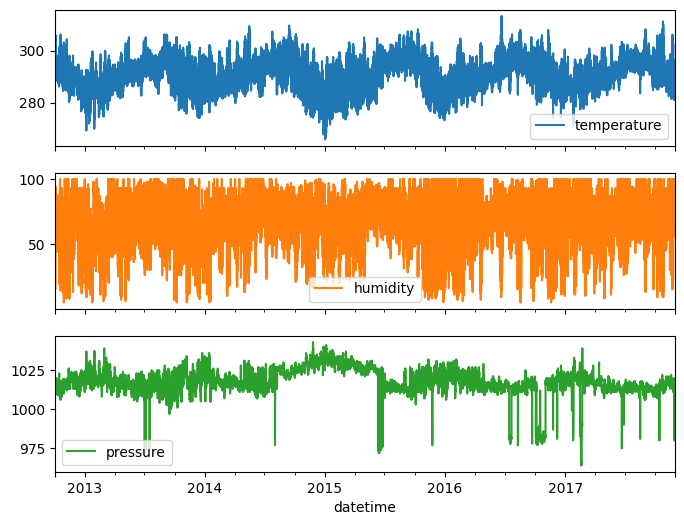

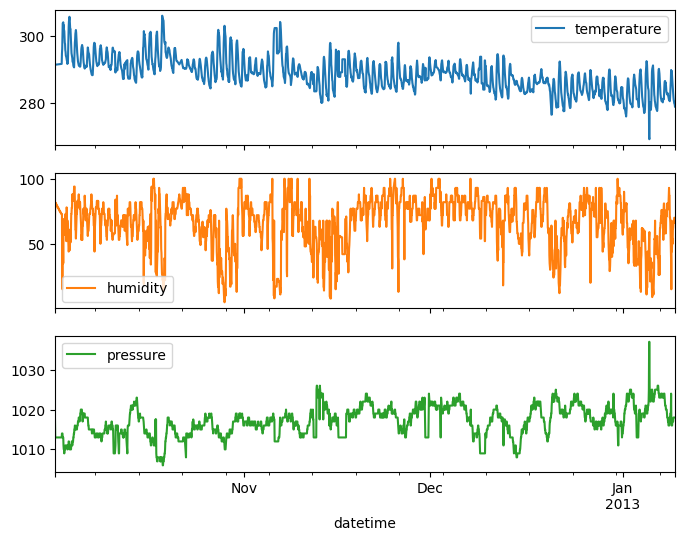

In [21]:
plot_cols = ['temperature', 'humidity', 'pressure']
plot_features = df_weather[plot_cols]
plot_features.index = df_weather['datetime']
_ = plot_features.plot(subplots=True)

plot_features = df_weather[plot_cols][:2400]
plot_features.index = df_weather['datetime'][:2400]
_ = plot_features.plot(subplots=True)

Przeliczenie wiatru z wartści kierunku w stopniach na współrzędne **x** oraz **y**

In [22]:
weather_count = df_weather[['wind_speed']].value_counts()
print(weather_count)

wind_speed
1.0           19031
2.0            8220
0.0            6852
3.0            5040
4.0            3478
5.0            1703
6.0             561
7.0             223
8.0              76
9.0              38
10.0             17
11.0              4
12.0              4
13.0              2
15.0              2
14.0              1
30.0              1
dtype: int64


Text(0, 0.5, 'Wind Velocity [m/s]')

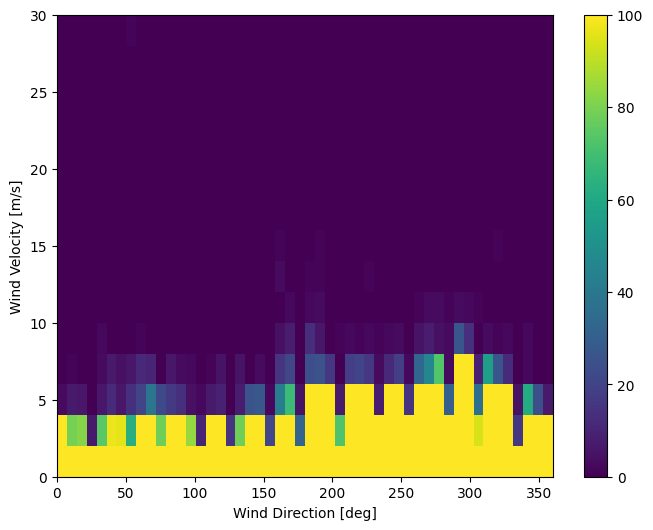

In [23]:
plt.hist2d(df_weather['wind_dir'], df_weather['wind_speed'], bins=(50, 15), vmax=100)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

In [24]:
wv = df_weather.pop('wind_speed')

# Konwersja na radiany
wd_rad = df_weather.pop('wind_dir')*np.pi / 180

# Wyliczanie składowe x oraz y
df_weather['Wx'] = wv*np.cos(wd_rad)
df_weather['Wy'] = wv*np.sin(wd_rad)

(-30.0, 30.0, -30.0, 30.0)

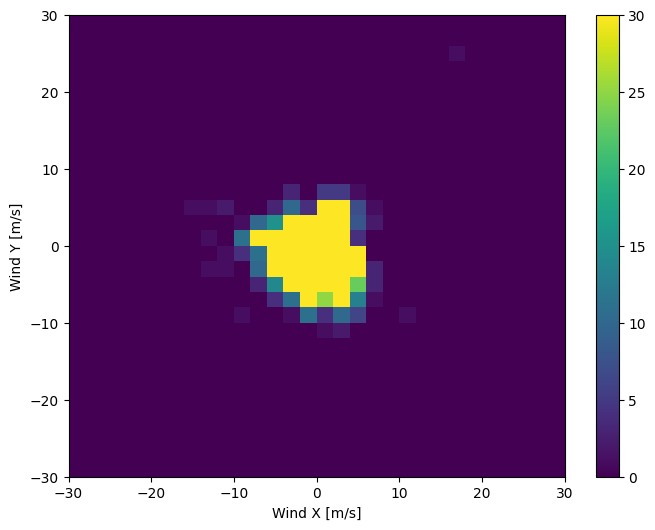

In [25]:
plt.hist2d(df_weather['Wx'], df_weather['Wy'], bins=(30, 30), vmax=30, range=[[-30, 30], [-30, 30]])
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [26]:
df_weather.head()

,datetime,temperature,humidity,pressure,rain_exists,cloud_exists,Wx,Wy
0,2012-10-01 12:00:00,291.530000,67.784809,1017.524491,False,False,0.0,0.0
1,2012-10-01 13:00:00,291.530000,82.000000,1013.000000,False,False,0.0,0.0
2,2012-10-01 14:00:00,291.533501,81.000000,1013.000000,False,False,0.0,0.0
3,2012-10-01 15:00:00,291.543355,81.000000,1013.000000,False,False,0.0,0.0
4,2012-10-01 16:00:00,291.553209,81.000000,1013.000000,False,False,0.0,0.0


Konwersja czasu na funkcję **Sin** i **Cos**



In [27]:
df = pd.DataFrame.from_dict(df_weather)

date_time = pd.to_datetime(df.pop('datetime'), format='%d.%m.%Y %H:%M:%S')

In [28]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [29]:
day = 24*60*60
year = (365.2425)*day

df_weather['day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df_weather['day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df_weather['year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df_weather['year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

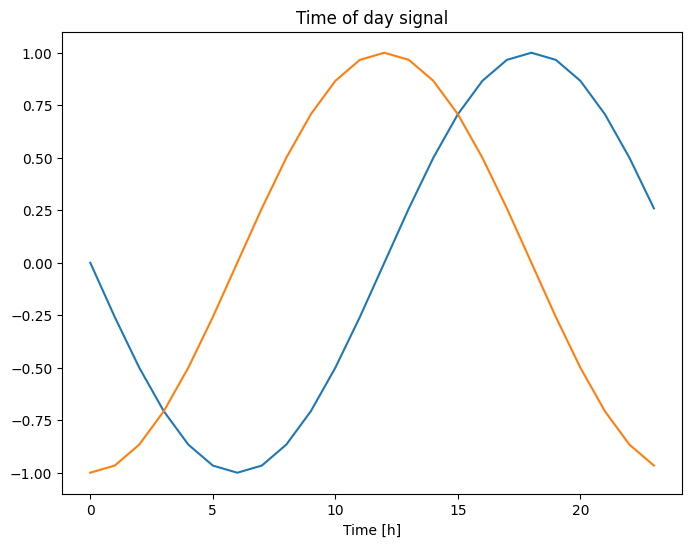

In [30]:
plt.plot(np.array(df_weather['day sin'])[:24])
plt.plot(np.array(df_weather['day cos'])[:24])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

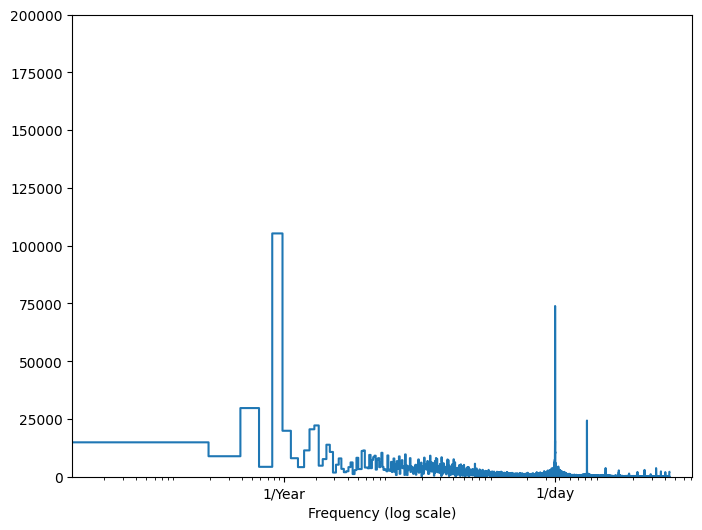

In [31]:
fft = tf.signal.rfft(df_weather['temperature'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df_weather['temperature'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 200000)
plt.xlim([0.01, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

Sprawdzenie wartości po zmianie

In [32]:
df_weather.head()

,datetime,temperature,humidity,pressure,rain_exists,cloud_exists,Wx,Wy,day sin,day cos,year sin,year cos
0,2012-10-01 12:00:00,291.530000,67.784809,1017.524491,False,False,0.0,0.0,1.177678e-12,-1.000000,-0.999978,0.006591
1,2012-10-01 13:00:00,291.530000,82.000000,1013.000000,False,False,0.0,0.0,-2.588190e-01,-0.965926,-0.999973,0.007308
2,2012-10-01 14:00:00,291.533501,81.000000,1013.000000,False,False,0.0,0.0,-5.000000e-01,-0.866025,-0.999968,0.008024
3,2012-10-01 15:00:00,291.543355,81.000000,1013.000000,False,False,0.0,0.0,-7.071068e-01,-0.707107,-0.999962,0.008741
4,2012-10-01 16:00:00,291.553209,81.000000,1013.000000,False,False,0.0,0.0,-8.660254e-01,-0.500000,-0.999955,0.009458


Konwersja temperatury na stopnie Celsjusza

In [33]:
df_weather['temperature'] = df_weather['temperature'].apply(lambda x: (x - 273.15))

In [34]:
df_timestamp = pd.DataFrame()
df_timestamp['datetime'] = pd.to_datetime(df_weather['datetime'])
df_weather.drop(columns=['datetime'], inplace=True)

Sprawdzenie wartości po zmianie

In [35]:
df_weather.head()

,temperature,humidity,pressure,rain_exists,cloud_exists,Wx,Wy,day sin,day cos,year sin,year cos
0,18.380000,67.784809,1017.524491,False,False,0.0,0.0,1.177678e-12,-1.000000,-0.999978,0.006591
1,18.380000,82.000000,1013.000000,False,False,0.0,0.0,-2.588190e-01,-0.965926,-0.999973,0.007308
2,18.383501,81.000000,1013.000000,False,False,0.0,0.0,-5.000000e-01,-0.866025,-0.999968,0.008024
3,18.393355,81.000000,1013.000000,False,False,0.0,0.0,-7.071068e-01,-0.707107,-0.999962,0.008741
4,18.403209,81.000000,1013.000000,False,False,0.0,0.0,-8.660254e-01,-0.500000,-0.999955,0.009458


In [36]:
df_timestamp.head()

,datetime
0,2012-10-01 12:00:00
1,2012-10-01 13:00:00
2,2012-10-01 14:00:00
3,2012-10-01 15:00:00
4,2012-10-01 16:00:00


Podział na zestawy danych

In [37]:
column_indices = {name: i for i, name in enumerate(df_weather.columns)}

n = len(df_weather)
df_train = df_weather[0:int(n*0.7)]
df_val = df_weather[int(n*0.7):int(n*0.9)]
df_test = df_weather[int(n*0.9):]

num_features = df_weather.shape[1]

In [38]:
df_train.head(8)

,temperature,humidity,pressure,rain_exists,cloud_exists,Wx,Wy,day sin,day cos,year sin,year cos
0,18.380000,67.784809,1017.524491,False,False,0.0,0.0,1.177678e-12,-1.000000e+00,-0.999978,0.006591
1,18.380000,82.000000,1013.000000,False,False,0.0,0.0,-2.588190e-01,-9.659258e-01,-0.999973,0.007308
2,18.383501,81.000000,1013.000000,False,False,0.0,0.0,-5.000000e-01,-8.660254e-01,-0.999968,0.008024
3,18.393355,81.000000,1013.000000,False,False,0.0,0.0,-7.071068e-01,-7.071068e-01,-0.999962,0.008741
4,18.403209,81.000000,1013.000000,False,False,0.0,0.0,-8.660254e-01,-5.000000e-01,-0.999955,0.009458
5,18.413063,80.000000,1013.000000,False,False,0.0,0.0,-9.659258e-01,-2.588190e-01,-0.999948,0.010175
6,18.422917,80.000000,1013.000000,False,False,0.0,0.0,-1.000000e+00,-3.741022e-12,-0.999941,0.010891
7,18.432772,80.000000,1013.000000,False,False,0.0,0.0,-9.659258e-01,2.588190e-01,-0.999933,0.011608


Normalziacja

In [39]:
train_mean = df_train.mean()
train_std = df_train.std()

#tu trzeba pamiętać że wartości z df_train zzapisywane są do train_df

# Inicjalziacja ramek danych

train_df = pd.DataFrame()
val_df = pd.DataFrame()
test_df = pd.DataFrame()

columns_to_normalize = ['temperature', 'humidity', 'pressure', 'Wx', 'Wy']

for col in columns_to_normalize:
    train_df[col] = (df_train[col] - train_mean[col]) / train_std[col]
    val_df[col] = (df_val[col] - train_mean[col]) / train_std[col]
    test_df[col] = (df_test[col] - train_mean[col]) / train_std[col]

columns_to_leave_unchanged = ['rain_exists', 'cloud_exists', 'day sin', 'day cos', 'year sin', 'year cos']

for col in columns_to_leave_unchanged:
    train_df[col] = df_train[col]
    val_df[col] = df_val[col]
    test_df[col] = df_test[col]

In [40]:
train_df.head(10)

,temperature,humidity,pressure,Wx,Wy,rain_exists,cloud_exists,day sin,day cos,year sin,year cos
0,0.314728,0.008352,-0.291971,-0.038793,0.463214,False,False,1.177678e-12,-1.000000e+00,-0.999978,0.006591
1,0.314728,0.738422,-0.938819,-0.038793,0.463214,False,False,-2.588190e-01,-9.659258e-01,-0.999973,0.007308
2,0.315309,0.687063,-0.938819,-0.038793,0.463214,False,False,-5.000000e-01,-8.660254e-01,-0.999968,0.008024
3,0.316946,0.687063,-0.938819,-0.038793,0.463214,False,False,-7.071068e-01,-7.071068e-01,-0.999962,0.008741
4,0.318583,0.687063,-0.938819,-0.038793,0.463214,False,False,-8.660254e-01,-5.000000e-01,-0.999955,0.009458
5,0.320220,0.635705,-0.938819,-0.038793,0.463214,False,False,-9.659258e-01,-2.588190e-01,-0.999948,0.010175
6,0.321857,0.635705,-0.938819,-0.038793,0.463214,False,False,-1.000000e+00,-3.741022e-12,-0.999941,0.010891
7,0.323495,0.635705,-0.938819,-0.038793,0.463214,False,False,-9.659258e-01,2.588190e-01,-0.999933,0.011608
8,0.325132,0.584347,-0.938819,-0.038793,0.463214,False,False,-8.660254e-01,5.000000e-01,-0.999924,0.012325
9,0.326769,0.584347,-0.938819,-0.038793,0.463214,False,False,-7.071068e-01,7.071068e-01,-0.999915,0.013041


In [41]:
train_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31677 entries, 0 to 31676
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temperature   31677 non-null  float64
 1   humidity      31677 non-null  float64
 2   pressure      31677 non-null  float64
 3   Wx            31677 non-null  float64
 4   Wy            31677 non-null  float64
 5   rain_exists   31677 non-null  bool   
 6   cloud_exists  31677 non-null  bool   
 7   day sin       31677 non-null  float64
 8   day cos       31677 non-null  float64
 9   year sin      31677 non-null  float64
 10  year cos      31677 non-null  float64
dtypes: bool(2), float64(9)
memory usage: 2.2 MB


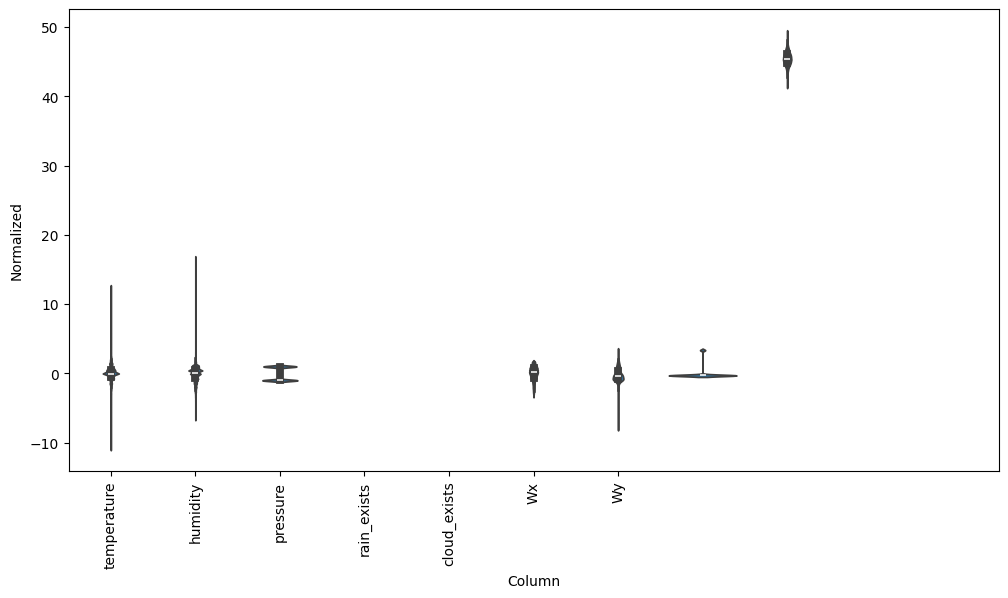

In [42]:
from matplotlib.ticker import FixedLocator, FixedFormatter

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
#_ = ax.set_xticklabels(df.keys(), rotation=90)
tick_positions = range(len(df.keys()))
ax.set_xticks(tick_positions)
ax.xaxis.set_major_locator(FixedLocator(tick_positions))
ax.xaxis.set_major_formatter(FixedFormatter(df.keys()))
ax.tick_params(axis='x', rotation=90)

Tworzenie okien czasowych

In [43]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [44]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['temperature'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['temperature']

In [45]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['temperature'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['temperature']

Funkcja dzieląca okna

In [46]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

    # Operacje wycinania nie zachowują informacji o wymiarach, dlatego ustawiamy wymiary ręcznie. W ten sposób `tf.data.Datasets` są łatwiejsze do inspekcji.

  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [47]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 11)
Inputs shape: (3, 6, 11)
Labels shape: (3, 1, 1)


Plot

In [48]:
w2.example = example_inputs, example_labels

In [49]:
def plot(self, model=None, plot_col='temperature', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

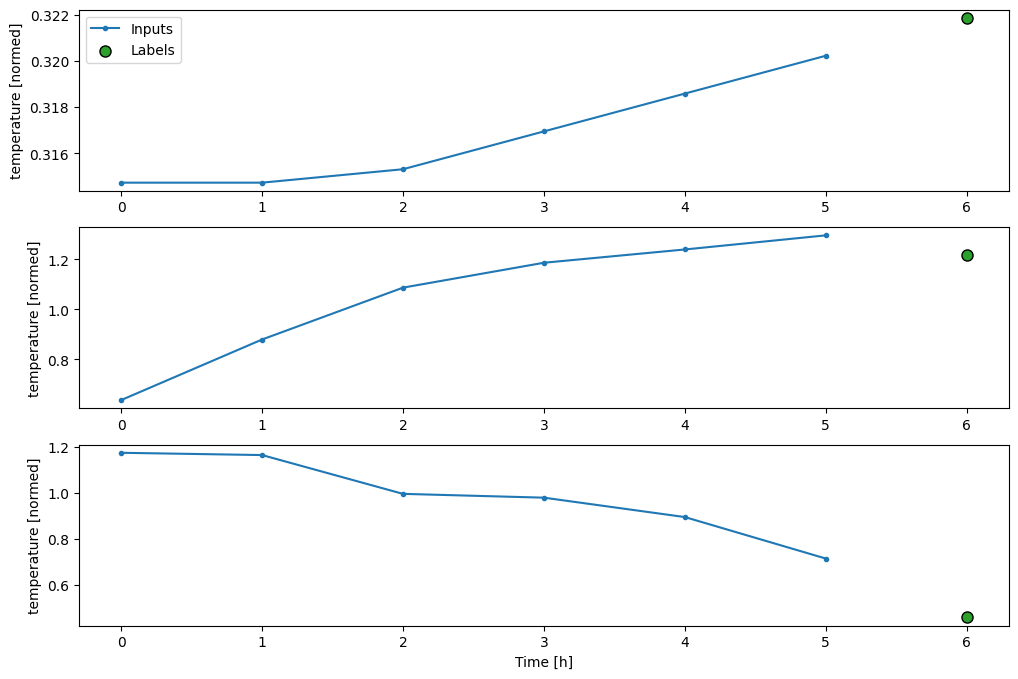

In [50]:
w2.plot()

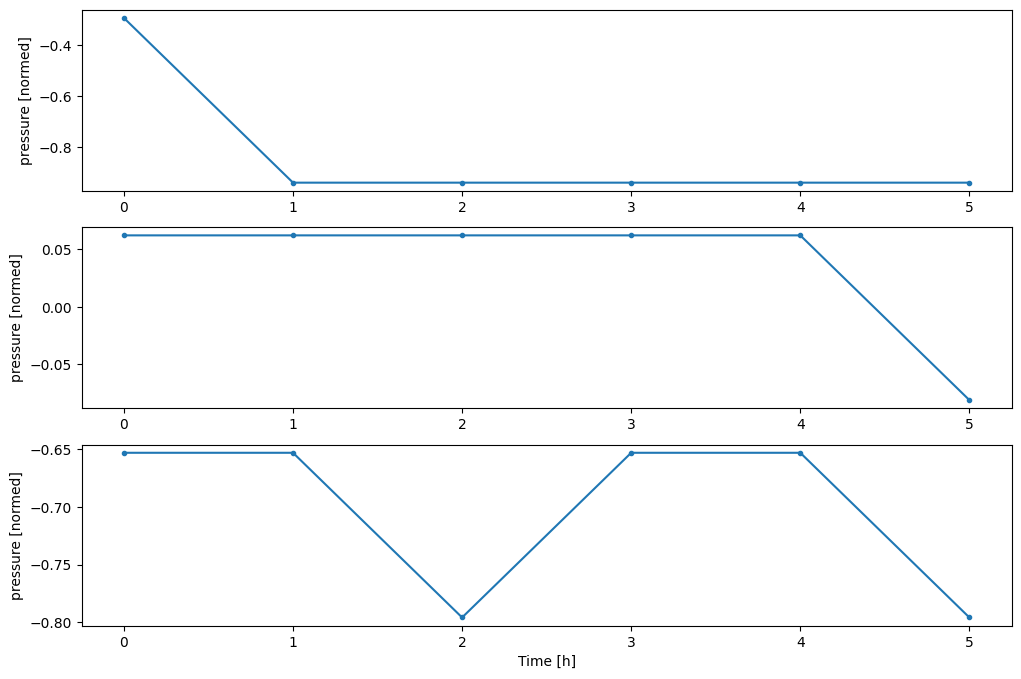

In [51]:
w2.plot(plot_col='pressure')

Funkcja tworząca datasety

In [52]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [53]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [54]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 11), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [55]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 11)
Labels shape (batch, time, features): (32, 1, 1)


Recurrent neural network

Multi-output model

Linear - regresja liniowa

In [56]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [57]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [58]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 11)
Labels shape (batch, time, features): (32, 24, 11)


In [59]:
history = compile_and_fit(linear, single_step_window)

val_performance = {}
performance = {}
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
990/990 [==============================] - 7s 5ms/step - loss: 0.8511 - mean_absolute_error: 0.7194 - val_loss: 1.0050 - val_mean_absolute_error: 0.7094
Epoch 2/20
990/990 [==============================] - 5s 5ms/step - loss: 0.6639 - mean_absolute_error: 0.6319 - val_loss: 0.9920 - val_mean_absolute_error: 0.6962
Epoch 3/20
990/990 [==============================] - 4s 4ms/step - loss: 0.6616 - mean_absolute_error: 0.6301 - val_loss: 0.9919 - val_mean_absolute_error: 0.6950
Epoch 4/20
990/990 [==============================] - 6s 6ms/step - loss: 0.6616 - mean_absolute_error: 0.6300 - val_loss: 0.9919 - val_mean_absolute_error: 0.6949
Epoch 5/20
283/283 [==============================] - 1s 3ms/step - loss: 0.9920 - mean_absolute_error: 0.6951


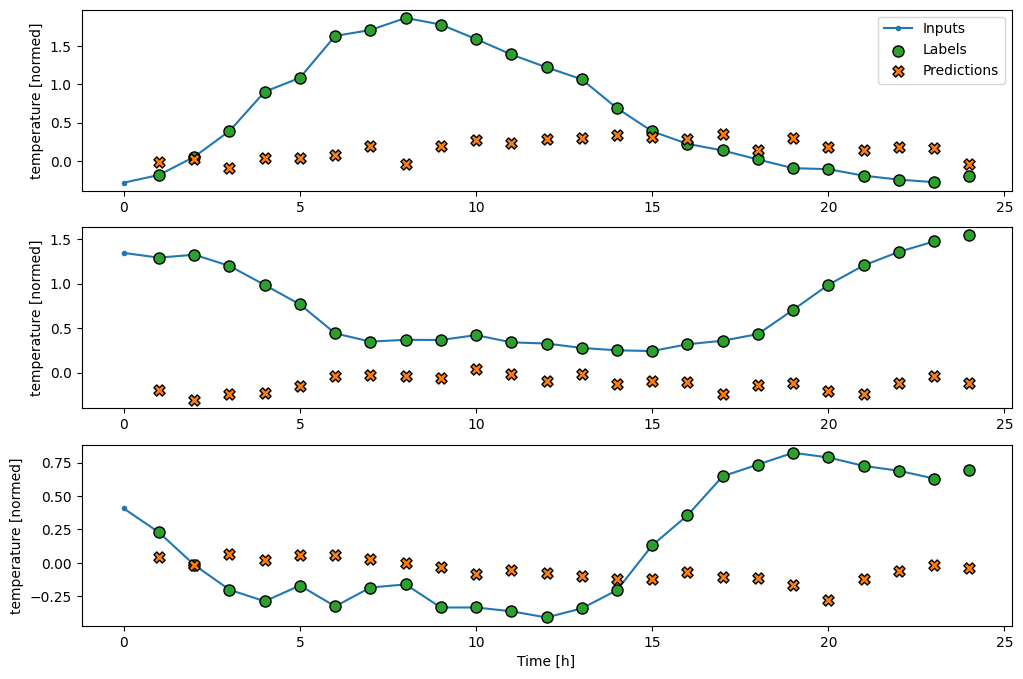

In [60]:
wide_window.plot(linear)

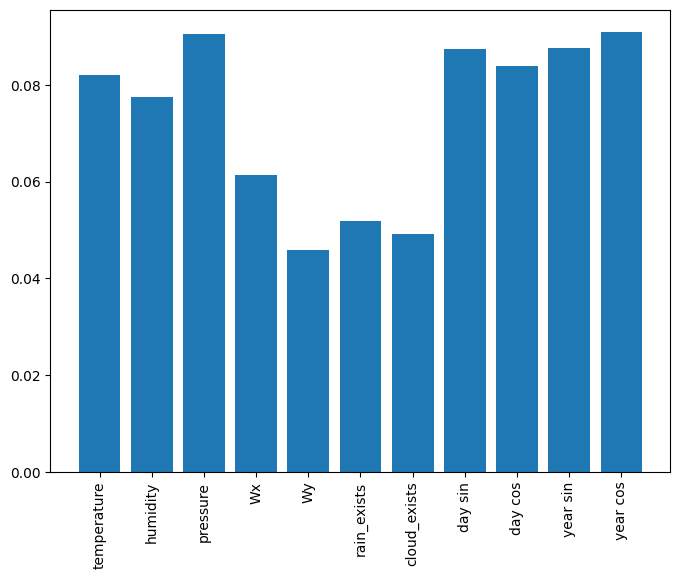

In [61]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [62]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Linear      : 0.6453


RSS

In [63]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)



Epoch 1/20
990/990 [==============================] - 12s 9ms/step - loss: 0.1756 - mean_absolute_error: 0.2474 - val_loss: 0.2020 - val_mean_absolute_error: 0.2319
Epoch 2/20
990/990 [==============================] - 9s 9ms/step - loss: 0.1232 - mean_absolute_error: 0.1801 - val_loss: 0.1853 - val_mean_absolute_error: 0.2158
Epoch 3/20
990/990 [==============================] - 7s 7ms/step - loss: 0.1191 - mean_absolute_error: 0.1731 - val_loss: 0.1803 - val_mean_absolute_error: 0.2107
Epoch 4/20
990/990 [==============================] - 7s 7ms/step - loss: 0.1172 - mean_absolute_error: 0.1700 - val_loss: 0.1775 - val_mean_absolute_error: 0.2085
Epoch 5/20
990/990 [==============================] - 8s 8ms/step - loss: 0.1160 - mean_absolute_error: 0.1683 - val_loss: 0.1763 - val_mean_absolute_error: 0.2067
Epoch 6/20
990/990 [==============================] - 9s 9ms/step - loss: 0.1150 - mean_absolute_error: 0.1673 - val_loss: 0.1740 - val_mean_absolute_error: 0.2055
Epoch 7/20
990/

In [64]:
IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

283/283 [==============================] - 1s 4ms/step - loss: 0.1722 - mean_absolute_error: 0.2039


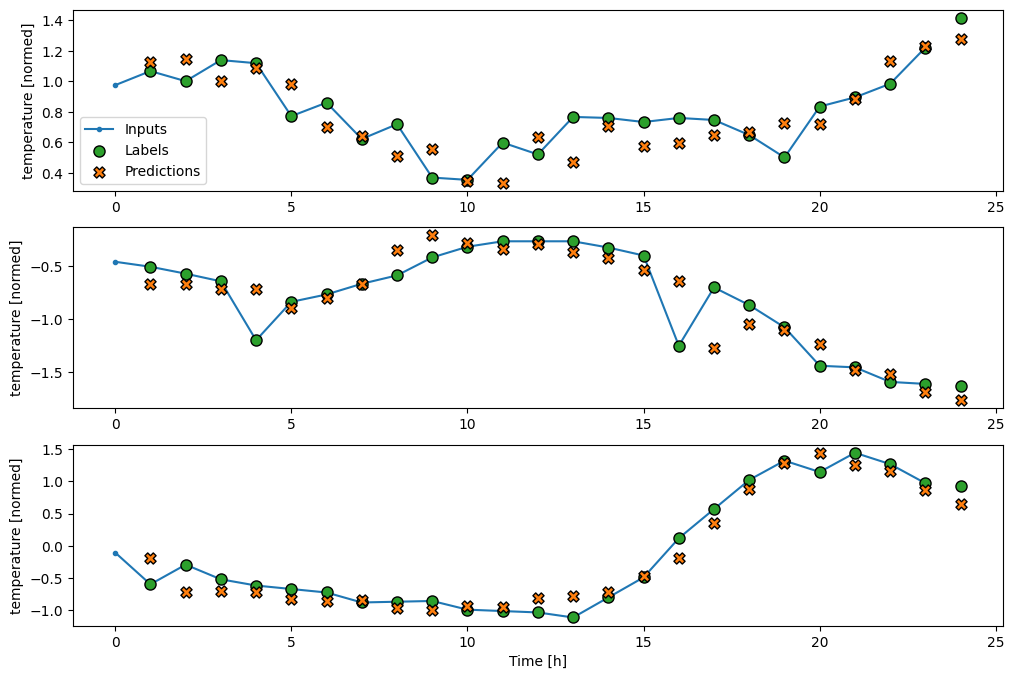

In [65]:
wide_window.plot(lstm_model)

Wykres porównania średniego błędu bezwzględnego dla modelu regresji liniowej z modelem sieci rekurencyjnej

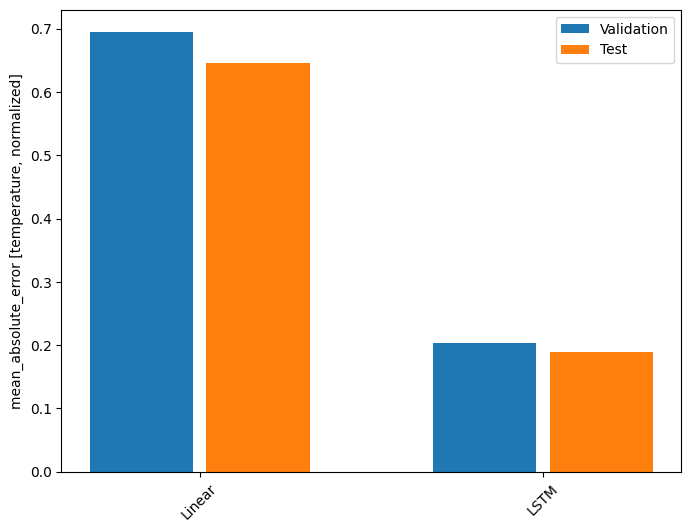

In [66]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [temperature, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

Wywołanie funkcji forecast_weather z wyuczonym modelem LSTM i oknem

In [67]:
def forecast_weather(model, window, day, hour):
    # Utwórz zbiór danych dla określonego dnia
    input_data = window.test.take(1)
    for inputs, labels in input_data:
        # Pobierz dane wejściowe dla określonego dnia i godziny
        inputs_for_day_hour = inputs[:, (day - 1) * 24 + hour - window.input_width:(day - 1) * 24 + hour, :]
        print("inputs_for_day_hour:", inputs_for_day_hour.shape)
        # Przewiduj pogodę dla wybranego dnia i godziny
        predictions = model.predict(inputs_for_day_hour)
        print("Predictions Dimensions:", predictions.shape)
        # Sprawdź, czy tablica predykcji nie jest pusta
        if predictions.size == 0:
            print("Brak dostępnych prognoz dla określonego dnia i godziny.")
            return
        # Denormalizuj prognozy, używając średniej i odchylenia standardowego z train_df
        units = ['°C', '%', 'MPa', '%', '%', 'm/s', 'm/s']
        for i in range(7):
            predicted_temperature = predictions[0, 0, i] * train_std[i] + train_mean[i]
            print(f"Predicted {train_std.index[i]}: {predicted_temperature:.2f} {units[i]}")
# Wywołaj funkcję forecast_weather z wyuczonym modelem LSTM i oknem
forecast_weather(lstm_model, wide_window, day=2, hour=8)

inputs_for_day_hour: (32, 16, 11)
1/1 [==============================] - 1s 575ms/step
Predictions Dimensions: (32, 16, 11)
Predicted temperature: 24.66 °C
Predicted humidity: 65.76 %
Predicted pressure: 1013.04 MPa
Predicted rain_exists: 0.11 %
Predicted cloud_exists: 0.72 %
Predicted Wx: 0.03 m/s
Predicted Wy: -0.41 m/s
